In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime
#%tensorboard --logdir logs/fit --bind_all

In [2]:
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from PIL import Image
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import os
from tqdm import tqdm

data_path = '/dmc/ml_storage/machine_learning/Final_ML_CBS/'
data_dir = '/dmc/ml_storage/machine_learning/Final_ML_CBS/data/aug/'

from model import *

2023-05-19 01:34:38.849093: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

2023-05-19 01:34:40.226235: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-05-19 01:34:40.226246: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-05-19 01:34:40.226701: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-19 01:34:40.248565: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2023-05-19 01:34:40.252535: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2023-05-19 01:34:40.253207: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-05-19 01:34:40.253244: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed


In [4]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

2023-05-19 01:34:40.268332: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-19 01:34:40.268458: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-19 01:34:40.268589: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.68GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.97GiB/s
2023-05-19 01:34:40.268598: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-05-19 01:34:40.271022: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-05-19 01:34:40.271046: I tensorflow/stream_executor/platform/

In [5]:
size = 224
input_dim = (size, size, 1)

In [6]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator()

datagen = image_generator.flow_from_directory(
        data_dir,
        target_size=(size, size),
        batch_size=1,
        color_mode='grayscale',
        class_mode=None,
        shuffle=False)

Found 21400 images belonging to 30 classes.


In [7]:
# get all the images from the generator and save them to a numpy array
train_images = []
for i in tqdm(range(len(datagen))):
    image = datagen[i]
    image = image.flatten()
    image = image.reshape((size, size, 1))
    train_images.append(image)

# for each image in the generator, split the class label into two separate labels using - as a seperator and add them to the generator
age_labels = []
gender_labels = []
for i in range(len(datagen.filenames)):
    datagen.filenames[i] = datagen.filenames[i].split('-')
    datagen.filenames[i][0] = int(datagen.filenames[i][0])
    datagen.filenames[i][1] = int(datagen.filenames[i][1].split('/')[0])
    age_labels.append(datagen.filenames[i][0])
    gender_labels.append(datagen.filenames[i][1])

100%|██████████| 21400/21400 [02:14<00:00, 159.68it/s]


In [8]:
# convert the labels to numpy arrays and combine them with the images
age_labels = np.array(age_labels).astype(np.float32)
gender_labels = np.array(gender_labels).astype(np.float32)
train_images = np.array(train_images).astype(np.float32)

# binarize the labels
gender_lb = LabelBinarizer()
gender_labels = gender_lb.fit_transform(gender_labels)

age_lb = LabelBinarizer()
age_labels = age_lb.fit_transform(age_labels)

X_train, X_val, y_train_age, y_val_age, y_train_gender, y_val_gender = train_test_split(train_images, age_labels, gender_labels, test_size=0.2, random_state=42)

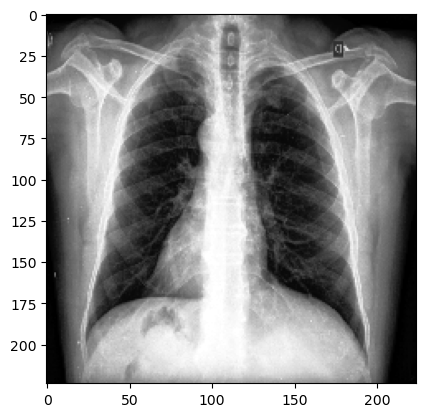

Age: [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
Gender: [1]


In [9]:
# Show a random train image and its labels
import matplotlib.pyplot as plt
import random
i = random.randint(0, len(X_train))
plt.imshow(X_train[i], cmap='gray')
plt.show()
print(f"Age: {y_train_age[i]}")
print(f"Gender: {y_train_gender[i]}")

In [10]:
classes = [15,1]
model = dual_net(input_dim, classes[0], classes[1], 0.0001)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

2023-05-19 01:37:01.733476: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-19 01:37:01.733660: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-05-19 01:37:01.733801: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-19 01:37:01.733945: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:08:00.0 name: NVIDIA GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.68GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.97Gi

In [ ]:
def step_decay(epoch, lr):
    if lr <= 0.00001:
        return 0.00002
    else:
        initial_lrate = 0.001
        drop = 0.75
        epochs_drop = 20.0
        lrate = initial_lrate * math.pow(drop,  
               math.floor((1+epoch)/epochs_drop))
        return lrate

optimizer = tf.keras.optimizers.Adam(0.001)

In [12]:
callbacks = [ModelCheckpoint('dual_model_3.hdf5', verbose=1, save_best_only=True, save_weights_only=True,
                             monitor = 'val_loss'),
             EarlyStopping(monitor = 'val_loss', patience = 16, restore_best_weights = True),
             LearningRateScheduler(step_decay, verbose=1), 
             tensorboard_callback]

In [13]:
losses = {
    "age": "categorical_crossentropy",
    "gender": "binary_crossentropy"
}
loss_weights = {"age": 1, "gender": 1}
metrics=['accuracy',
         tf.keras.metrics.TopKCategoricalAccuracy(),
         tf.keras.metrics.Precision(),
         tf.keras.metrics.Recall()]
model.compile(optimizer=optimizer,
    loss=losses,
    loss_weights=loss_weights,
    metrics=metrics)

In [14]:
epochs = 256
batch_size = 16

history = model.fit(
    x = X_train, 
    y = {'age': y_train_age, 'gender': y_train_gender},
    validation_data=
        (X_val, {'age': y_val_age, 'gender': y_val_gender}),
    epochs=epochs, 
    batch_size=batch_size,
    shuffle=True,
    callbacks=callbacks, 
    use_multiprocessing = True )

2023-05-19 01:37:02.140436: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3436052480 exceeds 10% of free system memory.
2023-05-19 01:37:03.533564: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-05-19 01:37:03.533807: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 4199690000 Hz


Epoch 1/256

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.


2023-05-19 01:37:04.679837: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-05-19 01:37:04.771669: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-05-19 01:37:06.306943: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


   2/1070 [..............................] - ETA: 2:49 - loss: 6.7832 - age_loss: 5.0727 - gender_loss: 1.2884 - age_accuracy: 0.0156 - age_top_k_categorical_accuracy: 0.2344 - age_precision: 0.0000e+00 - age_recall: 0.0000e+00 - gender_accuracy: 0.5000 - gender_top_k_categorical_accuracy: 1.0000 - gender_precision: 0.4451 - gender_recall: 0.4183       

2023-05-19 01:37:07.854692: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-05-19 01:37:07.854702: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-05-19 01:37:07.854763: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2023-05-19 01:37:07.985622: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-05-19 01:37:07.987674: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2023-05-19 01:37:07.988536: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-05-19 01:37:07.996606: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/20230519-013440/train/plugins/pro

1070/1070 [==============================] - ETA: 0s - loss: 3.8576 - age_loss: 2.8048 - gender_loss: 0.6902 - age_accuracy: 0.0997 - age_top_k_categorical_accuracy: 0.4415 - age_precision: 0.0998 - age_recall: 0.0022 - gender_accuracy: 0.6326 - gender_top_k_categorical_accuracy: 1.0000 - gender_precision: 0.5685 - gender_recall: 0.5021

2023-05-19 01:39:26.805699: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 859013120 exceeds 10% of free system memory.


1070/1070 [==============================] - 154s 140ms/step - loss: 3.8574 - age_loss: 2.8047 - gender_loss: 0.6901 - age_accuracy: 0.0997 - age_top_k_categorical_accuracy: 0.4415 - age_precision: 0.0998 - age_recall: 0.0022 - gender_accuracy: 0.6327 - gender_top_k_categorical_accuracy: 1.0000 - gender_precision: 0.5686 - gender_recall: 0.5021 - val_loss: 11.1358 - val_age_loss: 3.2849 - val_gender_loss: 7.5908 - val_age_accuracy: 0.1012 - val_age_top_k_categorical_accuracy: 0.4189 - val_age_precision: 0.0000e+00 - val_age_recall: 0.0000e+00 - val_gender_accuracy: 0.5876 - val_gender_top_k_categorical_accuracy: 1.0000 - val_gender_precision: 0.0000e+00 - val_gender_recall: 0.0000e+00

Epoch 00001: val_loss improved from inf to 11.13584, saving model to dual_model_3.hdf5
Epoch 2/256

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
1070/1070 [==============================] - 149s 139ms/step - loss: 3.3863 - age_loss: 2.5716 - gender_loss: 0.5665 - age_accuracy: 0.12


Epoch 00010: val_loss did not improve from 2.56611
Epoch 11/256

Epoch 00011: LearningRateScheduler reducing learning rate to 0.001.
1070/1070 [==============================] - 149s 139ms/step - loss: 2.4133 - age_loss: 2.0487 - gender_loss: 0.1868 - age_accuracy: 0.2064 - age_top_k_categorical_accuracy: 0.8096 - age_precision: 0.4623 - age_recall: 4.9804e-04 - gender_accuracy: 0.9323 - gender_top_k_categorical_accuracy: 1.0000 - gender_precision: 0.9220 - gender_recall: 0.9158 - val_loss: 2.5429 - val_age_loss: 2.0669 - val_gender_loss: 0.3017 - val_age_accuracy: 0.2236 - val_age_top_k_categorical_accuracy: 0.7930 - val_age_precision: 0.0000e+00 - val_age_recall: 0.0000e+00 - val_gender_accuracy: 0.8699 - val_gender_top_k_categorical_accuracy: 1.0000 - val_gender_precision: 0.9927 - val_gender_recall: 0.6895

Epoch 00011: val_loss improved from 2.56611 to 2.54290, saving model to dual_model_3.hdf5
Epoch 12/256

Epoch 00012: LearningRateScheduler reducing learning rate to 0.001.
1070


Epoch 00020: val_loss improved from 2.29001 to 2.27289, saving model to dual_model_3.hdf5
Epoch 21/256

Epoch 00021: LearningRateScheduler reducing learning rate to 0.0005.
1070/1070 [==============================] - 149s 139ms/step - loss: 2.1943 - age_loss: 1.8856 - gender_loss: 0.1392 - age_accuracy: 0.2619 - age_top_k_categorical_accuracy: 0.8653 - age_precision: 0.5999 - age_recall: 0.0023 - gender_accuracy: 0.9500 - gender_top_k_categorical_accuracy: 1.0000 - gender_precision: 0.9440 - gender_recall: 0.9378 - val_loss: 2.9790 - val_age_loss: 2.0690 - val_gender_loss: 0.7461 - val_age_accuracy: 0.2192 - val_age_top_k_categorical_accuracy: 0.8136 - val_age_precision: 0.3333 - val_age_recall: 7.0093e-04 - val_gender_accuracy: 0.7311 - val_gender_top_k_categorical_accuracy: 1.0000 - val_gender_precision: 0.6055 - val_gender_recall: 0.9983

Epoch 00021: val_loss did not improve from 2.27289
Epoch 22/256

Epoch 00022: LearningRateScheduler reducing learning rate to 0.0005.
1070/1070 


Epoch 00030: val_loss did not improve from 2.13624
Epoch 31/256

Epoch 00031: LearningRateScheduler reducing learning rate to 0.0005.
1070/1070 [==============================] - 148s 139ms/step - loss: 2.0169 - age_loss: 1.7513 - gender_loss: 0.1178 - age_accuracy: 0.2933 - age_top_k_categorical_accuracy: 0.9104 - age_precision: 0.4826 - age_recall: 0.0143 - gender_accuracy: 0.9593 - gender_top_k_categorical_accuracy: 1.0000 - gender_precision: 0.9523 - gender_recall: 0.9517 - val_loss: 2.0946 - val_age_loss: 1.8494 - val_gender_loss: 0.0973 - val_age_accuracy: 0.2734 - val_age_top_k_categorical_accuracy: 0.8867 - val_age_precision: 1.0000 - val_age_recall: 7.0093e-04 - val_gender_accuracy: 0.9680 - val_gender_top_k_categorical_accuracy: 1.0000 - val_gender_precision: 0.9805 - val_gender_recall: 0.9411

Epoch 00031: val_loss improved from 2.13624 to 2.09462, saving model to dual_model_3.hdf5
Epoch 32/256

Epoch 00032: LearningRateScheduler reducing learning rate to 0.0005.
1070/1070 


Epoch 00040: val_loss improved from 1.98425 to 1.95428, saving model to dual_model_3.hdf5
Epoch 41/256

Epoch 00041: LearningRateScheduler reducing learning rate to 0.00025.
1070/1070 [==============================] - 149s 139ms/step - loss: 1.8396 - age_loss: 1.6022 - gender_loss: 0.0792 - age_accuracy: 0.3400 - age_top_k_categorical_accuracy: 0.9431 - age_precision: 0.5230 - age_recall: 0.0322 - gender_accuracy: 0.9727 - gender_top_k_categorical_accuracy: 1.0000 - gender_precision: 0.9650 - gender_recall: 0.9702 - val_loss: 2.0310 - val_age_loss: 1.7930 - val_gender_loss: 0.0804 - val_age_accuracy: 0.2974 - val_age_top_k_categorical_accuracy: 0.8993 - val_age_precision: 0.5096 - val_age_recall: 0.0124 - val_gender_accuracy: 0.9752 - val_gender_top_k_categorical_accuracy: 1.0000 - val_gender_precision: 0.9647 - val_gender_recall: 0.9756

Epoch 00041: val_loss did not improve from 1.95428
Epoch 42/256

Epoch 00042: LearningRateScheduler reducing learning rate to 0.00025.
1070/1070 [=


Epoch 00050: val_loss did not improve from 1.93250
Epoch 51/256

Epoch 00051: LearningRateScheduler reducing learning rate to 0.00025.
1070/1070 [==============================] - 148s 139ms/step - loss: 1.6588 - age_loss: 1.4399 - gender_loss: 0.0576 - age_accuracy: 0.3952 - age_top_k_categorical_accuracy: 0.9669 - age_precision: 0.5802 - age_recall: 0.0759 - gender_accuracy: 0.9771 - gender_top_k_categorical_accuracy: 1.0000 - gender_precision: 0.9696 - gender_recall: 0.9762 - val_loss: 2.0963 - val_age_loss: 1.8440 - val_gender_loss: 0.0904 - val_age_accuracy: 0.2710 - val_age_top_k_categorical_accuracy: 0.9229 - val_age_precision: 0.3623 - val_age_recall: 0.0633 - val_gender_accuracy: 0.9745 - val_gender_top_k_categorical_accuracy: 1.0000 - val_gender_precision: 0.9615 - val_gender_recall: 0.9773

Epoch 00051: val_loss did not improve from 1.93250
Epoch 52/256

Epoch 00052: LearningRateScheduler reducing learning rate to 0.00025.
1070/1070 [==============================] - 148s 1

1070/1070 [==============================] - 148s 139ms/step - loss: 1.4891 - age_loss: 1.2741 - gender_loss: 0.0451 - age_accuracy: 0.4652 - age_top_k_categorical_accuracy: 0.9807 - age_precision: 0.6079 - age_recall: 0.1559 - gender_accuracy: 0.9831 - gender_top_k_categorical_accuracy: 1.0000 - gender_precision: 0.9807 - gender_recall: 0.9782 - val_loss: 2.0520 - val_age_loss: 1.7985 - val_gender_loss: 0.0835 - val_age_accuracy: 0.3182 - val_age_top_k_categorical_accuracy: 0.9297 - val_age_precision: 0.4133 - val_age_recall: 0.0974 - val_gender_accuracy: 0.9764 - val_gender_top_k_categorical_accuracy: 1.0000 - val_gender_precision: 0.9690 - val_gender_recall: 0.9739

Epoch 00061: val_loss did not improve from 1.93250
Epoch 62/256

Epoch 00062: LearningRateScheduler reducing learning rate to 0.000125.
1070/1070 [==============================] - 149s 139ms/step - loss: 1.4646 - age_loss: 1.2521 - gender_loss: 0.0425 - age_accuracy: 0.4716 - age_top_k_categorical_accuracy: 0.9835 - age

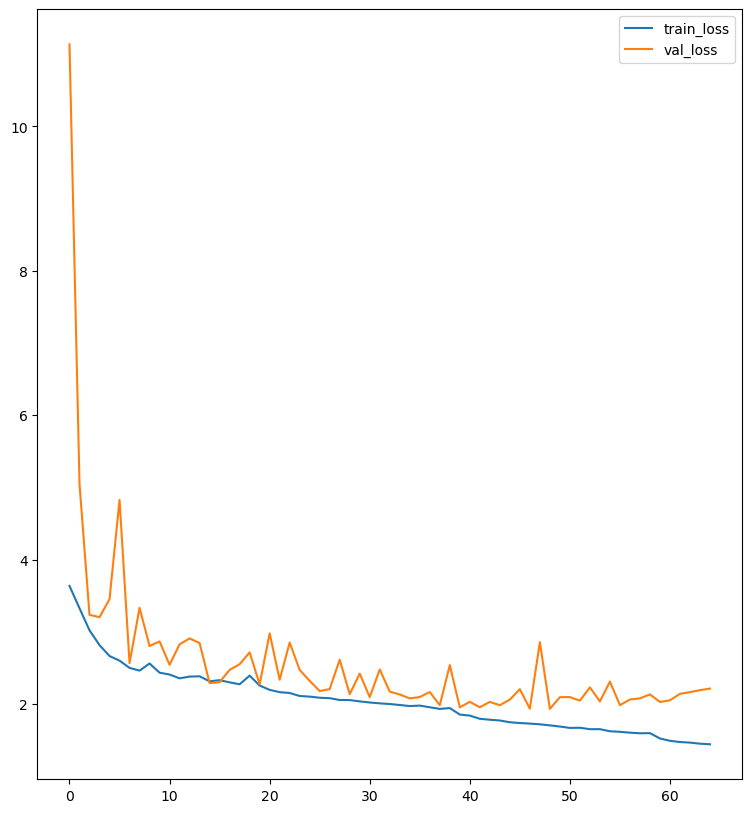

In [15]:
# plot the training and validation loss and accuracy
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [16]:
# take a random omage from the validation set and predict its labels using the model, also print the actual labels
#i = random.randint(0, len(X_val))
plt.imshow(X_val[i], cmap='gray')

# load the best weights
model.load_weights('dual_model.hdf5')

print('Actual age: ', y_val_age[i])
print('Actual gender:', y_val_gender[i])

pred = model.predict(X_val[i].reshape(1, size, size, 1))

print('Predicted age: ', pred[0])
print('Predicted gender: ', pred[1])

IndexError: index 14704 is out of bounds for axis 0 with size 4280

In [17]:
# evaluate the model on the validation set and print metics accuray, precision, recall and AUC

model.evaluate(X_val, {'age': y_val_age, 'gender': y_val_gender})

2023-05-19 08:01:15.756235: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 859013120 exceeds 10% of free system memory.
2023-05-19 08:01:16.188563: W tensorflow/core/common_runtime/bfc_allocator.cc:248] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


134/134 [==============================] - 11s 76ms/step - loss: 1.9325 - age_loss: 1.6914 - gender_loss: 0.0808 - age_accuracy: 0.3175 - age_top_k_categorical_accuracy: 0.9334 - age_precision: 0.5057 - age_recall: 0.0313 - gender_accuracy: 0.9773 - gender_top_k_categorical_accuracy: 1.0000 - gender_precision: 0.9664 - gender_recall: 0.9790


[1.9324969053268433,
 1.691396951675415,
 0.08077774941921234,
 0.31752336025238037,
 0.9334112405776978,
 0.505660355091095,
 0.03130841255187988,
 0.9773364663124084,
 1.0,
 0.9664429426193237,
 0.979036808013916]